In [1]:
import numpy as np
import pandas as pd


from bs4 import BeautifulSoup, Tag
import base64, io
from io import BytesIO


import os
import re
import json


from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


pd.set_option("display.max_colwidth", 50) 

In [2]:
SOURCE_PATH = "/Users/mac/Desktop/!ai bootcamp/!Intro to ML/homeworks/FINAL PROJECT/FINAL PROJECT files"
BLANK_FILE = "pixel.gif" #Заглушка

YEARS = range(2002, 2008)

# 1. Получение данных

## Задачи А

In [3]:
FILE_NAME = "Демонстрационный вариант ЕГЭ 2002. Физика. Часть А..html"

# читаем текст
with open(f"{SOURCE_PATH}/{FILE_NAME}", "r", encoding="utf-8", errors="ignore") as f:
    html_text = f.read()

# парсим
soup = BeautifulSoup(html_text, "html.parser")

# все div без class="ans"
tasks = [d for d in soup.find_all("div") if not d.has_attr("class")]

# все div с class="ans"
answers = soup.find_all("div", class_="ans")

print("Задачи:", len(tasks))
print("Ответы:", len(answers))

Задачи: 38
Ответы: 35


In [4]:
soup

<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">

<!-- saved from url=(0048)https://sverh-zadacha.ucoz.ru/ege/2002/2002A.htm -->
<html xmlns="http://www.w3.org/1999/xhtml"><head><meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<link href="./Демонстрационный вариант ЕГЭ 2002. Физика. Часть А._files/2002.css" rel="stylesheet" type="text/css"/>
<title>Демонстрационный вариант ЕГЭ 2002. Физика. Часть А.</title>
<meta content="TestMaker VVZ 2.6" name="generator"/>
<script language="JavaScript" src="./Демонстрационный вариант ЕГЭ 2002. Физика. Часть А._files/2002.js" type="text/JavaScript"></script>
<style type="text/css">
<!--
p.MsoNormal {
margin:0cm;
margin-bottom:.0001pt;
font-size:12.0pt;
font-family:"Times New Roman","serif";
}
-->
</style>
</head>
<body alink="#FF0000" background="./Демонстрационный вариант ЕГЭ 2002. Физика. Часть А._files/bg.gif" bgcolor="#FFFFFF" link="#004080" onload="in

### Возможные варианты размещени img:
Пример 1 (В задачах):
```html
<div><b> <img height="10" name="a11" src="./Демонстрационный вариант ЕГЭ 2002. Физика. Часть А._files/pixel.gif"
                  width="10"/> A11. Тепловой двигатель за цикл получает от нагревателя количество теплоты, равное 3 кДж
        и отдает холодильнику количество теплоты, равное 2,4 кДж. КПД двигателя равен</b></div>
```

Пример 2 (В ответах):
```html
<div class="ans"><
    img align="right" alt="рис.16" border="1" height="61"
    src="./Демонстрационный вариант ЕГЭ 2002. Физика. Часть А._files/2002_clip_image002_0004.gif" width="70"/>
        <input name="r16" type="radio" value="15"/>
        влево<br/><br/><input name="r16" type="radio" value="15"/>
        вправо<br/><br/><input name="r16" type="radio" value="15"/>
        вверх<br/><br/><input name="r16" type="radio" value="15"/>
        вниз
</div>
```


Пример 3 (Вне тэга div):
```html
<img align="right" alt="рис.21" border="1" height="186"
         src="./Демонстрационный вариант ЕГЭ 2002. Физика. Часть А._files/2002_clip_image002_0006.gif" width="404"/>
    
<div><b> <img height="10" name="a21" src="./Демонстрационный вариант ЕГЭ 2002. Физика. Часть А._files/pixel.gif"
                  width="10"/> 
        A21. Если осветить красным светом лазерной указки два близких отверстия S<sub>1</sub> и S<sub>2</sub>
        , проколотые тонкой иглой в фольге, то за ней на экране наблюдаются два пятна. По мере удаления экрана Э они
        увеличиваются в размере, пятна начинают перекрываться и возникает чередование красных и темных полос.

        Что будет наблюдаться в точке А, если S<sub>1</sub>A = S<sub>2</sub>A? Фольга Ф расположена перпендикулярно
        лазерному пучку.
        <br/>
    </b></div>
    
<div class="ans"><input name="r21" type="radio" value="20"/>
        середина красной полосы<br/>
        <br/>
        <input name="r21" type="radio" value="20"/>
        середина темной полосы<br/>
        <br/>
        <input name="r21" type="radio" value="20"/>
        переход от темной к красной полосе<br/>
        <br/>
        <input name="r21" type="radio" value="20"/>
        нельзя дать однозначный ответ<br/>
</div>
```

In [5]:
def get_task_textA(div):
    text = div.get_text(" ", strip=True)

    # ищем номера: латинская/кириллическая A + цифры + необязательная точка
    match = re.search(r"[AА]\d{1,2}\.?", text)
    if not match:
        return None

    m = re.match(r"([AА]\d+\.?)\s*(.*)", text)
    if not m:
        return None

    num = m.group(1)
    problem = m.group(2)
    
    return {
        'Number' : num,
        'Task': problem
    }
    

In [6]:
def get_choices(ans_div):
    """Парсит один <div class="ans"> и возвращает список вариантов ответа"""
    choices = []
    for inp in ans_div.find_all("input", {"type": "radio"}):
        text_parts = []
        sib = inp.next_sibling
        # собираем текст до следующего input
        while sib and not (getattr(sib, "name", None) == "input"):
            if hasattr(sib, "get_text"):   # если это тег (например <sub>)
                text_parts.append(sib.get_text())
            else:                          # если просто текст
                text_parts.append(str(sib))
            sib = sib.next_sibling
        choice = "".join(text_parts).replace("\xa0", " ").strip()
        if choice:
            choices.append(choice)
    return json.dumps(choices)

In [7]:
dfs = []

for year in YEARS:
    FILE_NAME = f"Демонстрационный вариант ЕГЭ {year}. Физика. Часть А..html"
    print(f'Год {year}')
    
    # читаем текст
    with open(f"{SOURCE_PATH}/{FILE_NAME}", "r", encoding="utf-8", errors="ignore") as f:
        html_text = f.read()
    
    # парсим
    soup = BeautifulSoup(html_text, "html.parser")

    for form in soup.find_all("form"):
        form.unwrap()

    hrs = soup.find_all('hr')


    tasks = []

    for i in range(len(hrs) - 2):
        # взять всё между hrs[i] и hrs[i+1]
        image = []
        task = {
            'Images': []
        }
    
        for sib in hrs[i].next_siblings:        
        
            if getattr(sib, "name", None):  # только теги            
                if sib.name == "hr": 
                    break
            
                if sib.name == "img":
                    task['Images'].append(sib["src"])
            
                if (sib.name == "div" and not sib.has_attr("class")):
                    task_text = get_task_textA(sib)
                    if task_text != None:
                        task.update(task_text)
                if (sib.name == "div" and sib.has_attr("class")):
                    task['Choices'] = get_choices(sib)
            
                
                for inner_img in sib.find_all("img"):
                    src = inner_img.get("src")
                    if BLANK_FILE not in src:
                        task['Images'].append(inner_img.get("src"))
            
    
        tasks.append(task)
        
    df = pd.DataFrame(tasks)
    df['Year'] = year
    df['Images'] = df['Images'].apply(lambda x: json.dumps(x) if isinstance(x, list) else json.dumps([x]))
    dfs.append(df)

dfA = pd.concat(dfs, ignore_index=True)

Год 2002
Год 2003
Год 2004
Год 2005
Год 2006
Год 2007


In [8]:
dfA

Images Number  \
0    ["./\u0414\u0435\u043c\u043e\u043d\u0441\u0442...    A1.   
1    ["./\u0414\u0435\u043c\u043e\u043d\u0441\u0442...    A2.   
2                                                   []    A3.   
3                                                   []    A4.   
4                                                   []    A5.   
..                                                 ...    ...   
180  ["./\u0414\u0435\u043c\u043e\u043d\u0441\u0442...   A26.   
181                                                 []   A27.   
182                                                 []   А28.   
183                                                 []   A29.   
184  ["./\u0414\u0435\u043c\u043e\u043d\u0441\u0442...   A30.   

                                                  Task  \
0    На рисунке представлен график зависимости коор...   
1    На рис. А показаны направления скорости и уско...   
2    На рычаг действуют две силы, плечи которых рав...   
3    Предлагается два объяснения того экспериментал...   
4    Тележка массой m, движущаяся со скоростью v, с...   
..                                                 ...   
180  На  рисунках А, Б, В приведены спектры излучен...   
181  Какая из  строчек таблицы правильно отражает с...   
182  Полоний 214 84 Po превращается в висмут 210 83...   
183  Красная  граница фотоэффекта исследуемого мета...   
184  В лаборатории исследовалась зависимость напряж...   

                                               Choices  Year  
0    ["v1  > v2  = v3", "v1  > v2  > v3", "v1  < v2...  2002  
1                                 ["1", "2", "3", "4"]  2002  
2    ["1 \u041d", "6 \u041d", "9 \u041d", "12 \u041d"]  2002  
3    ["\u0442\u043e\u043b\u044c\u043a\u043e \u0410"...  2002  
4                           ["0", "mv/2", "mv", "2mv"]  2002  
..                                                 ...   ...  
180  ["\u043d\u0435  \u0441\u043e\u0434\u0435\u0440...  2007  
181                                                NaN  2007  
182  ["\u043e\u0434\u043d\u043e\u0433\u043e \u03b1 ...  2007  
183  ["133 \u043d\u043c", "300 \u043d\u043c", "400 ...  2007  
184                                                 []  2007  

[185 rows x 5 columns]

## Задачи B

In [9]:
FILE_NAME = "Часть B. 2004 год.html"

# читаем текст
with open(f"{SOURCE_PATH}/{FILE_NAME}", "r", encoding="utf-8", errors="ignore") as f:
    html_text = f.read()

# парсим
soup = BeautifulSoup(html_text, "html.parser")

In [10]:
def get_task_textB(div):
    text = div.get_text(" ", strip=True)

    # ищем номера: латинская/кириллическая A + цифры + необязательная точка
    match = re.search(r"[BВ]\d{1,2}\.?", text)
    if not match:
        return None

    m = re.match(r"([BВ]\d+\.?)\s*(.*)", text)
    if not m:
        return None

    num = m.group(1)
    problem = m.group(2)
    
    return {
        'Number' : num,
        'Task': problem
    }
    

In [11]:
dfs = []

for year in YEARS:
    FILE_NAME = f"Часть B. {year} год.html"
    print(f'Год {year}')
    
    # читаем текст
    with open(f"{SOURCE_PATH}/{FILE_NAME}", "r", encoding="utf-8", errors="ignore") as f:
        html_text = f.read()
    
    # парсим
    soup = BeautifulSoup(html_text, "html.parser")
    
    for form in soup.find_all("form"):
        form.unwrap()

    hrs = soup.find_all('hr')

    tasks = []

    for i in range(len(hrs) - 2):
        # взять всё между hrs[i] и hrs[i+1]
        image = []
        task = {
            'Images': []
        }
    
        for sib in hrs[i].next_siblings:        
        
            if getattr(sib, "name", None):  # только теги            
                if sib.name == "hr": 
                    break
            
                if sib.name == "img":
                    task['Images'].append(sib["src"])
            
                if (sib.name == "div"):
                    task_text = get_task_textB(sib)
                    if task_text != None:
                        task.update(task_text)
                    for inner_img in sib.find_all("img"):
                        src = inner_img.get("src")
                        if BLANK_FILE not in src:
                            task['Images'].append(inner_img.get("src"))
    
        tasks.append(task)
        
        

    df = pd.DataFrame(tasks)
    df['Year'] = year
    df['Choices'] = 'nan'
    df['Images'] = df['Images'].apply(lambda x: json.dumps(x) if isinstance(x, list) else json.dumps([x]))
    dfs.append(df)
    

dfB = pd.concat(dfs, ignore_index=True)

Год 2002
Год 2003
Год 2004
Год 2005
Год 2006
Год 2007


In [12]:
dfB

Images Number  \
0   ["./\u0427\u0430\u0441\u0442\u044c B. 2002 \u0...    B1.   
1                                                  []    B2.   
2   ["./\u0427\u0430\u0441\u0442\u044c B. 2002 \u0...    B3.   
3                                                  []    B4.   
4                                                  []    B5.   
5                                                  []    B1.   
6                                                  []    B2.   
7                                                  []    B3.   
8                                                  []    B4.   
9   ["./\u0427\u0430\u0441\u0442\u044c B. 2003 \u0...    B5.   
10                                                 []    B1.   
11  ["./\u0427\u0430\u0441\u0442\u044c B. 2004 \u0...    B2.   
12                                                 []    B3.   
13                                                 []    B4.   
14  ["./\u0427\u0430\u0441\u0442\u044c B. 2004 \u0...    B5.   
15                                                 []    B1.   
16  ["./\u0427\u0430\u0441\u0442\u044c B. 2005 \u0...    B2.   
17                                                 []    B3.   
18                                                 []    B4.   
19                                                 []    B1.   
20                                                 []    B2.   
21                                                 []    B3.   
22                                                 []    B4.   
23                                                 []    B1.   
24                                                 []    B2.   
25                                                 []    B3.   
26                                                 []    B4.   

                                                 Task  Year Choices  
0   Маленький кубик массы 2 кг может скользить без...  2002     nan  
1   Чему равно изменение внутренней энергии газа, ...  2002     nan  
2   Ученик исследовал зависимость показаний амперм...  2002     nan  
3   Карандаш совмещен с главной оптической осью то...  2002     nan  
4   При освещении ультрафиолетовым светом с частот...  2002     nan  
5   Шарик, прикрепленный к пружине, совершает  гар...  2003     nan  
6   Какое количество теплоты выделится при изобарн...  2003     nan  
7   Замкнутый проводник сопротивлением R  = 3 Ом н...  2003     nan  
8   Выполняя экспериментальное задание, ученик дол...  2003     nan  
9   Определите энергию,  выделившуюся при протекан...  2003     nan  
10  Автомобиль движется по выпуклому мосту. При ка...  2004     nan  
11  Рассчитайте  количество теплоты, сообщенное од...  2004     nan  
12  В катушке  сила тока равномерно увеличивается ...  2004     nan  
13  Изображение предмета, расположенного на рассто...  2004     nan  
14  На  фотографии представлен спектр излучения во...  2004     nan  
15  За 2 с прямолинейного равноускоренного движени...  2005     nan  
16  На рисунке  показан процесс изменения состояни...  2005     nan  
17  В  таблице показано, как изменялся заряд конде...  2005     nan  
18  На  поверхность пластинки из стекла нанесена п...  2005     nan  
19  Небольшой камень, брошенный с ровной горизонта...  2006     nan  
20  Для  определения удельной теплоты плавления ль...  2006     nan  
21  При  лечении электростатическим душем к электр...  2006     nan  
22  Дифракционная  решетка с периодом 10 –5 м расп...  2006     nan  
23  Небольшой камень, брошенный с ровной горизонта...  2007     nan  
24  1 моль инертного газа сжали, совершив работу 6...  2007     nan  
25  В электрическом поле, вектор напряженности кот...  2007     nan  
26  Карандаш совмещен с главной оптической осью то...  2007     nan

## Задачи C

In [13]:
def get_task_textC(div):
    text = div.get_text(" ", strip=True)

    # ищем номера: латинская/кириллическая A + цифры + необязательная точка
    match = re.search(r"[СC]\d{1,2}\.?", text)
    if not match:
        return None

    m = re.match(r"([СC]\d+\.?)\s*(.*)", text)
    if not m:
        return None

    num = m.group(1)
    problem = m.group(2)
    
    return {
        'Number' : num,
        'Task': problem
    }
    

In [14]:
FILE_NAME = "Часть С. 2002 год.html"

# читаем текст
with open(f"{SOURCE_PATH}/{FILE_NAME}", "r", encoding="utf-8", errors="ignore") as f:
    html_text = f.read()

# парсим
soup = BeautifulSoup(html_text, "html.parser")

In [15]:
soup

<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">

<!-- saved from url=(0048)https://sverh-zadacha.ucoz.ru/ege/2002/2002C.htm -->
<html xmlns="http://www.w3.org/1999/xhtml"><head><meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<link href="./Часть С. 2002 год_files/2002.css" rel="stylesheet" type="text/css"/>
<title>Часть С.  2002 год</title>
<meta content="TestMaker VVZ 2.6" name="generator"/>
<style type="text/css">
<!--
.стиль2 {font-family: "Times New Roman", Times, serif}
-->
   </style>
<style type="text/css">
   <!--
p.MsoNormal {
margin:0cm;
margin-bottom:.0001pt;
font-size:12.0pt;
font-family:"Times New Roman","serif";
}
-->
   </style>
</head>
<body alink="#FF0000" background="./Часть С. 2002 год_files/bg.gif" bgcolor="#FFFFFF" link="#004080" onload="init()" text="#004080" vlink="#004080">
<table border="0" cellpadding="0" cellspacing="0" width="100%">
<tbody><tr>
<td background="./Час

In [16]:
dfs = []

for year in YEARS:
    FILE_NAME = f"Часть С. {year} год.html"
    print(f'Год {year}')
    
    # читаем текст
    with open(f"{SOURCE_PATH}/{FILE_NAME}", "r", encoding="utf-8", errors="ignore") as f:
        html_text = f.read()
    
    # парсим
    soup = BeautifulSoup(html_text, "html.parser")
    
    for form in soup.find_all("form"):
        form.unwrap()

    hrs = soup.find_all('hr')

    tasks = []

    for i in range(len(hrs) - 1):
        # взять всё между hrs[i] и hrs[i+1]
        image = []
        task = {
            'Images': []
        }
    
        for sib in hrs[i].next_siblings:        
        
            if getattr(sib, "name", None):  # только теги            
                if sib.name == "hr": 
                    break
            
                if sib.name == "img":
                    task['Images'].append(sib["src"])
            
                if (sib.name == "div"):
                    task_text = get_task_textC(sib)
                    if task_text != None:
                        task.update(task_text)
                    for inner_img in sib.find_all("img"):
                        src = inner_img.get("src")
                        if BLANK_FILE not in src:
                            task['Images'].append(inner_img.get("src"))
    
        tasks.append(task)
        
        

    df = pd.DataFrame(tasks)
    df['Year'] = year
    df['Choices'] = 'nan'
    df['Images'] = df['Images'].apply(lambda x: json.dumps(x) if isinstance(x, list) else json.dumps([x]))
    dfs.append(df)
    

dfC = pd.concat(dfs, ignore_index=True)
dfC

Год 2002
Год 2003
Год 2004
Год 2005
Год 2006
Год 2007


Images Number  \
0   ["./\u0427\u0430\u0441\u0442\u044c \u0421. 200...    С1.   
1   ["./\u0427\u0430\u0441\u0442\u044c \u0421. 200...    С2.   
2   ["./\u0427\u0430\u0441\u0442\u044c \u0421. 200...    С3.   
3                                                  []    С4.   
4                                                  []    С5.   
5                                                  []    С1.   
6                                                  []    С2.   
7                                                  []    С3.   
8                                                  []    С4.   
9                                                  []    С5.   
10  ["./\u0427\u0430\u0441\u0442\u044c \u0421. 200...    С1.   
11                                                 []    С2.   
12                                                 []    С3.   
13                                                 []    С4.   
14  ["./\u0427\u0430\u0441\u0442\u044c \u0421. 200...    С5.   
15                                                 []    С1.   
16  ["./\u0427\u0430\u0441\u0442\u044c \u0421. 200...    С2.   
17  ["./\u0427\u0430\u0441\u0442\u044c \u0421. 200...    С3.   
18                                                 []    С4.   
19                                                 []    С5.   
20                                                 []    С6.   
21                                                 []    С1.   
22  ["./\u0427\u0430\u0441\u0442\u044c \u0421. 200...    С2.   
23  ["./\u0427\u0430\u0441\u0442\u044c \u0421. 200...    С3.   
24                                                 []    С4.   
25                                                 []    С5.   
26                                                 []    С6.   
27  ["./\u0427\u0430\u0441\u0442\u044c \u0421. 200...    С1.   
28                                                 []    С2.   
29                                                 []    С3.   
30                                                 []    С4.   
31                                                 []    С5.   
32  ["./\u0427\u0430\u0441\u0442\u044c \u0421. 200...    С6.   

                                                 Task  Year Choices  
0   Шайба, брошенная вдоль наклонной плоскости, ск...  2002     nan  
1   Рассчитайте КПД тепловой машины, использующей ...  2002     nan  
2   Чему равна энергия конденсатора емкости С, под...  2002     nan  
3   На дифракционную решетку с периодом d = 0,01 м...  2002     nan  
4   С какой скоростью вылетает α -частица из радио...  2002     nan  
5   Тележка массой 0,8 кг движется по инерции со с...  2003     nan  
6   Некоторое количество гелия расширяется: сначал...  2003     nan  
7   Маленький заряженный шарик массой 50 г, имеющи...  2003     nan  
8   При облучении металла светом с длиной волны 24...  2003     nan  
9   Вакуумный диод, у которого анод (положительный...  2003     nan  
10  Два  тела, массы которых соответственно m 1 = ...  2004     nan  
11  В медный  стакан калориметра массой 200 г, сод...  2004     nan  
12  В кинескопе телевизора разность потенциалов ме...  2004     nan  
13  В вакууме находятся два покрытых кальцием элек...  2004     nan  
14  На рисунке представлена фотография установки  ...  2004     nan  
15  Масса Марса составляет 0,1 от массы Земли,  ди...  2005     nan  
16  10 моль идеального одноатомного газа охладили,...  2005     nan  
17  Ученик собрал электрическую цепь, состоящую из...  2005     nan  
18  Объектив проекционного аппарата имеет оптическ...  2005     nan  
19  Фотоны, имеющие энергию 5 эВ, выбивают электро...  2005     nan  
20  Электрон влетает в область однородного магнитн...  2005     nan  
21  Масса Марса составляет 0,1 от массы Земли,  ди...  2006     nan  
22  1 моль идеального одноатомного газа сначала ох...  2006     nan  
23  Ученик собрал электрическую цепь, состоящую из...  2006     nan  
24  На экране с помощью тонкой линзы получено изоб...  2006     nan  
25  Какова максимальная скорость электронов, выбив

## Объедениe Задач

In [17]:
dfA.head()

Images Number  \
0  ["./\u0414\u0435\u043c\u043e\u043d\u0441\u0442...    A1.   
1  ["./\u0414\u0435\u043c\u043e\u043d\u0441\u0442...    A2.   
2                                                 []    A3.   
3                                                 []    A4.   
4                                                 []    A5.   

                                                Task  \
0  На рисунке представлен график зависимости коор...   
1  На рис. А показаны направления скорости и уско...   
2  На рычаг действуют две силы, плечи которых рав...   
3  Предлагается два объяснения того экспериментал...   
4  Тележка массой m, движущаяся со скоростью v, с...   

                                             Choices  Year  
0  ["v1  > v2  = v3", "v1  > v2  > v3", "v1  < v2...  2002  
1                               ["1", "2", "3", "4"]  2002  
2  ["1 \u041d", "6 \u041d", "9 \u041d", "12 \u041d"]  2002  
3  ["\u0442\u043e\u043b\u044c\u043a\u043e \u0410"...  2002  
4                         ["0", "mv/2", "mv", "2mv"]  2002

In [18]:
dfB.head()

Images Number  \
0  ["./\u0427\u0430\u0441\u0442\u044c B. 2002 \u0...    B1.   
1                                                 []    B2.   
2  ["./\u0427\u0430\u0441\u0442\u044c B. 2002 \u0...    B3.   
3                                                 []    B4.   
4                                                 []    B5.   

                                                Task  Year Choices  
0  Маленький кубик массы 2 кг может скользить без...  2002     nan  
1  Чему равно изменение внутренней энергии газа, ...  2002     nan  
2  Ученик исследовал зависимость показаний амперм...  2002     nan  
3  Карандаш совмещен с главной оптической осью то...  2002     nan  
4  При освещении ультрафиолетовым светом с частот...  2002     nan

In [19]:
dfC.head()

Images Number  \
0  ["./\u0427\u0430\u0441\u0442\u044c \u0421. 200...    С1.   
1  ["./\u0427\u0430\u0441\u0442\u044c \u0421. 200...    С2.   
2  ["./\u0427\u0430\u0441\u0442\u044c \u0421. 200...    С3.   
3                                                 []    С4.   
4                                                 []    С5.   

                                                Task  Year Choices  
0  Шайба, брошенная вдоль наклонной плоскости, ск...  2002     nan  
1  Рассчитайте КПД тепловой машины, использующей ...  2002     nan  
2  Чему равна энергия конденсатора емкости С, под...  2002     nan  
3  На дифракционную решетку с периодом d = 0,01 м...  2002     nan  
4  С какой скоростью вылетает α -частица из радио...  2002     nan

In [20]:
df = pd.concat([dfA, dfB, dfC], ignore_index=True)

In [21]:
df['Images'].iloc[1]

'["./\\u0414\\u0435\\u043c\\u043e\\u043d\\u0441\\u0442\\u0440\\u0430\\u0446\\u0438\\u043e\\u043d\\u043d\\u044b\\u0438\\u0306 \\u0432\\u0430\\u0440\\u0438\\u0430\\u043d\\u0442 \\u0415\\u0413\\u042d 2002. \\u0424\\u0438\\u0437\\u0438\\u043a\\u0430. \\u0427\\u0430\\u0441\\u0442\\u044c \\u0410._files/2002_clip_image002_0000.gif"]'

In [22]:
df.shape

(245, 5)

# 2. Подготовка к Streamlit

In [23]:
def get_images_files(paths, source_path=SOURCE_PATH):
    """собираем картинки"""
    img_b64_list = []
    img_list = json.loads(paths)
    
    for path in img_list:
        img_path = os.path.join(source_path, path.lstrip("./"))        
        try:
            with open(img_path, "rb") as f:
                img_b64 = base64.b64encode(f.read()).decode("utf-8")
                img_b64_list.append(img_b64)
        except FileNotFoundError:
            pass
    
    return json.dumps(img_b64_list)



def show_images(row):
    img_list = json.loads(row)
    for img_b64 in img_list:
        img_bytes = base64.b64decode(img_b64)
        img = Image.open(BytesIO(img_bytes))
        plt.imshow(img)
        plt.axis("off") 
        plt.show()


def check_parsing(df):
    """для проверки получившегося результата"""
    for row_n in range(df.shape[0]):
        row = df.iloc[row_n] 
        print(f'Задача: {row["Number"]}')
        print(f'Условие: {row["Task"]}')
        show_images(row["Images"])
        print('\n' * 3)

## Картинки в формате base64

In [24]:
df['Images'] = df['Images'].apply(get_images_files)

In [25]:
df.sample()

Images Number                                               Task Choices  \
206     []    B3.  При  лечении электростатическим душем к электр...     nan   

     Year  
206  2006

## Задача - Номер

In [26]:
df.sample()

Images Number                                               Task Choices  \
238     []    С6.  Две параллельные неподвижные диэлектрические п...     nan   

     Year  
238  2006

In [27]:
df['Level'] = df['Number'].str[0]
df['Number'] = df['Number'].str.rstrip(".").str[1:].astype(int)

In [28]:
df.head()

Images  Number  \
0  ["R0lGODlhoQClAHcAMSH+GlNvZnR3YXJlOiBNaWNyb3Nv...       1   
1  ["R0lGODlhLgFNAHcAMSH+GlNvZnR3YXJlOiBNaWNyb3Nv...       2   
2                                                 []       3   
3                                                 []       4   
4                                                 []       5   

                                                Task  \
0  На рисунке представлен график зависимости коор...   
1  На рис. А показаны направления скорости и уско...   
2  На рычаг действуют две силы, плечи которых рав...   
3  Предлагается два объяснения того экспериментал...   
4  Тележка массой m, движущаяся со скоростью v, с...   

                                             Choices  Year Level  
0  ["v1  > v2  = v3", "v1  > v2  > v3", "v1  < v2...  2002     A  
1                               ["1", "2", "3", "4"]  2002     A  
2  ["1 \u041d", "6 \u041d", "9 \u041d", "12 \u041d"]  2002     A  
3  ["\u0442\u043e\u043b\u044c\u043a\u043e \u0410"...  2002     A  
4                         ["0", "mv/2", "mv", "2mv"]  2002     A

## Вывод 

In [29]:
def show_A(df):
    for _, row in df.iterrows():
        print(f"Задача: \n {row['Task']}")
        choices = json.loads(row['Choices'])
        for i, ch in enumerate(choices, 1):
            print(f"{i}) {ch}")
        show_images(row['Images'])

Задача: 
 На рисунке представлен график зависимости координаты тела, движущегося вдоль оси OX, от времени. Сравните скорости v 1 , v 2 и v 3 тела в моменты времени t 1 , t 2 , t 3 .
1) v1  > v2  = v3
2) v1  > v2  > v3
3) v1  < v2  < v3
4) v1  = v2  > v3


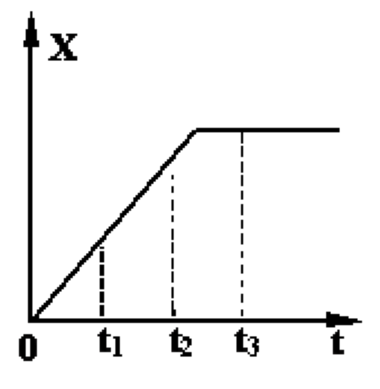

Задача: 
 На рис. А показаны направления скорости и ускорения тела в данный момент времени. Какая из стрелок (1-4) на рис. Б соответствует направлению результирующей всех сил, действующих на тело.
1) 1
2) 2
3) 3
4) 4


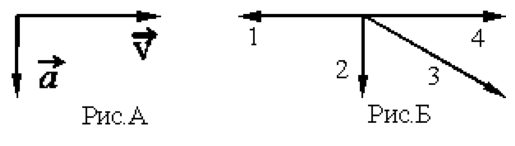

Задача: 
 На рычаг действуют две силы, плечи которых равны 0,1 м и 0,3 м. Сила, действующая на короткое плечо, равна 3 Н. Чему должна быть равна сила, действующая на длинное плечо, чтобы рычаг был в равновесии?
1) 1 Н
2) 6 Н
3) 9 Н
4) 12 Н
Задача: 
 Предлагается два объяснения того экспериментального факта, что ускорение свободного падения  не зависит от массы тел. А. В соответствии с третьим законом Ньютона два тела притягиваются друг к другу с одинаковой силой, поэтому они и падают на Землю с одинаковым ускорением. Б. В соответствии с законом всемирного тяготения сила тяжести пропорциональна массе, а в соответствии со вторым законом Ньютона ускорение обратно пропорционально массе. Поэтому любые тела при свободном падении движутся с одинаковым ускорением. Какое из них является верным?
1) только А
2) только Б
3) и А, и Б
4) ни А, ни Б
Задача: 
 Тележка массой m, движущаяся со скоростью v, сталкивается с неподвижной тележкой той же массы и сцепляется с ней. Импульс тележек после взаимод

In [30]:
show_A(df[:5])

# 3. Проверка

Задача: 1
Условие: Автомобиль движется по прямой улице. На графике представлена зависимость скорости автомобиля от времени. Модуль ускорения максимален в интервале времени


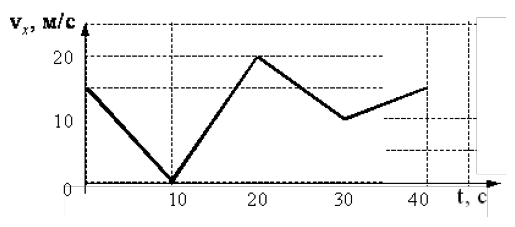





Задача: 2
Условие: Две  материальные точки движутся по окружностям радиусами R 1 и R 2 ,  причем R 2 = 2R 1 . При условии равенства линейных  скоростей точек их центростремительные ускорения связаны соотношением




Задача: 3
Условие: Парашютист  спускается вертикально с постоянной скоростью 2 м/с. Систему отсчета, связанную  с Землей, считать инерциальной. В этом случае




Задача: 4
Условие: Для  измерения жесткости пружины ученик собрал установку (см. рис.1), и подвесил к  пружине груз массой 0,1 кг (см. рис.2). Какова жесткость пружины?


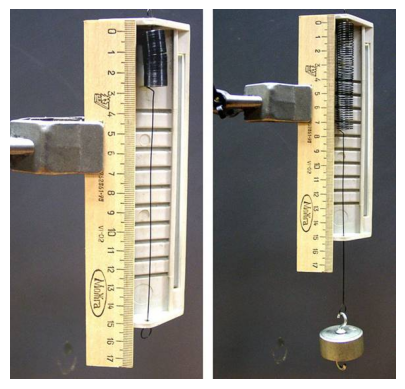





Задача: 5
Условие: В широкую  U-образную трубку с вертикальными прямыми коленами налиты  неизвестная жидкость плотностью ρ 1 и вода плотностью ρ 2 = 1,0 . 10 3 кг/м 3 (см. рисунок). На  рисунке b = 10 см, h = 24 см, H = 30 см. Плотность жидкости ρ 1 равна


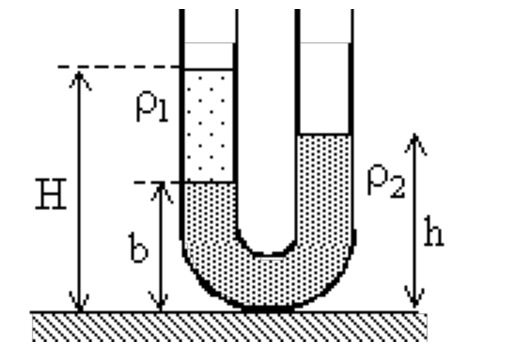





Задача: 6
Условие: Два автомобиля одинаковой массы m движутся со скоростями v и 2v относительно Земли по одной прямой в  противоположных направлениях. Чему равен модуль импульса второго автомобиля в  системе отсчета, связанной с первым автомобилем?




Задача: 7
Условие: На  рисунке изображена зависимость амплитуды установившихся колебаний маятника от  частоты вынуждающей силы (резонансная кривая). Отношение амплитуды установившихся колебаний  маятника на резонансной частоте к амплитуде колебаний на частоте 0,5 Гц равно


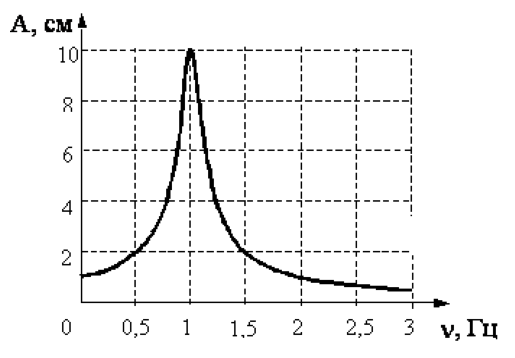





Задача: 8
Условие: Брусок массой 0,5 кг прижат к вертикальной стене силой  10 H, направленной горизонтально. Коэффициент трения скольжения между  бруском и стеной равен 0,4. Какую минимальную силу надо приложить к бруску по  вертикали, чтобы равномерно поднимать его вертикально вверх?




Задача: 9
Условие: Скорость  брошенного мяча непосредственно перед ударом о стену была вдвое больше его  скорости сразу после удара. При ударе выделилось количество теплоты, равное  15 Дж. Найдите кинетическую энергию мяча перед ударом.




Задача: 10
Условие: 3 моль  водорода находятся в сосуде при температуре  Т. Какова температура 3 моль кислорода в сосуде того же объема и при том  же давлении? (Водород и кислород считать идеальными газами.)




Задача: 11
Условие: Внутренняя  энергия газа в запаянном несжимаемом сосуде определяется главным образом




Задача: 12
Условие: При  одинаковой температуре 100°С  давление  насыщенных паров воды равно 10 5 Па, аммиака — 59 . 10 5 Па и ртути — 37 Па. В 

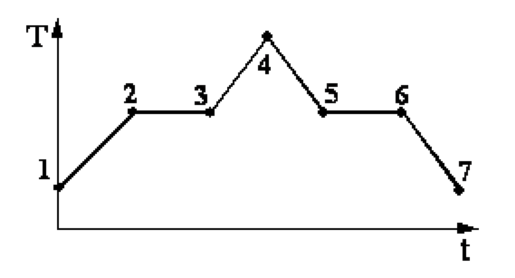





Задача: 14
Условие: На  диаграмме (см. рисунок) показан процесс изменения состояния идеального одноатомного  газа. Газ отдает 50 кДж теплоты. Работа внешних сил равна


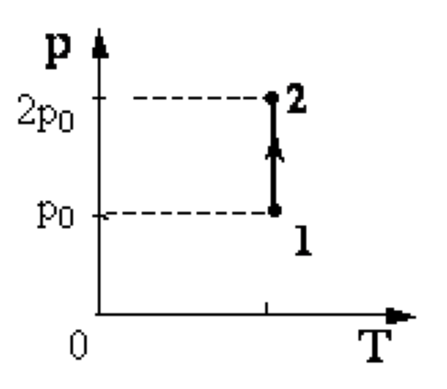





Задача: 15
Условие: В сосуде  постоянного объема находится идеальный газ, массу которого изменяют. На диаграмме  (см. рисунок) показан процесс изменения состояния газа. В какой из точек  диаграммы масса газа наибольшая?


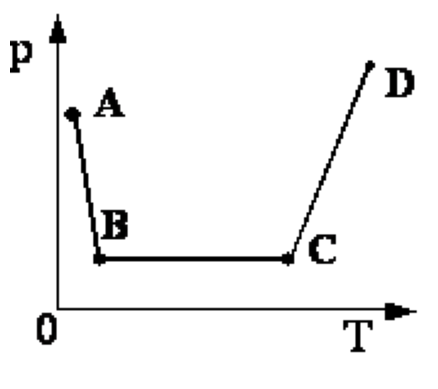





Задача: 16
Условие: Пылинка,  имевшая отрицательный заряд –10 е, при освещении потеряла четыре  электрона. Каким стал заряд пылинки?




Задача: 17
Условие: К  бесконечной горизонтальной отрицательно заряженной плоскости  привязана невесомая нить с шариком, имеющим  положительный заряд (см. рисунок). Каково условие равновесия шарика, если mg   –  модуль силы тяжести, F э – модуль  силы электростатического взаимодействия шарика с пластиной,  Т – модуль силы натяжения нити?


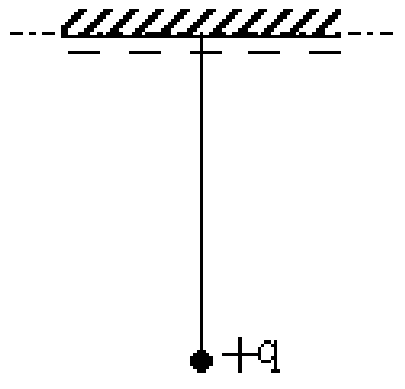





Задача: 18
Условие: Через  участок цепи (см. рисунок) течет постоянный ток I = 10 А.  Какую силу тока показывает амперметр? Сопротивлением амперметра пренебречь.


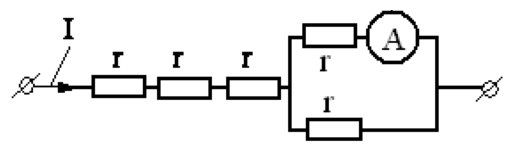





Задача: 19
Условие: В  электронагревателе, через который течет постоянный ток, за время t выделяется  количество теплоты Q. Если сопротивление нагревателя и время t  увеличить вдвое, не изменяя силу тока, то количество выделившейся теплоты будет  равно




Задача: 20
Условие: На  рисунке изображен проволочный виток, по которому течет электрический ток в  направлении, указанном стрелкой. Виток расположен в горизонтальной плоскости. В  центре витка вектор индукции магнитного поля тока направлен


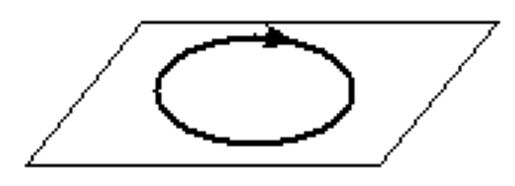





Задача: 21
Условие: Инфракрасное излучение испускают




Задача: 22
Условие: Угол  падения света на  горизонтально  расположенное плоское зеркало равен 30°. Каким будет угол между падающим и  отраженным лучами, если повернуть зеркало на 10° так, как показано на рисунке?


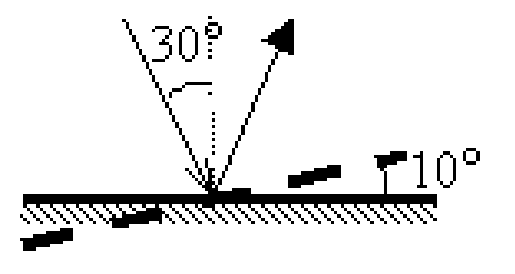





Задача: 23
Условие: На  рисунке показаны два способа вращения рамки в однородном магнитном поле. Ток в  рамке


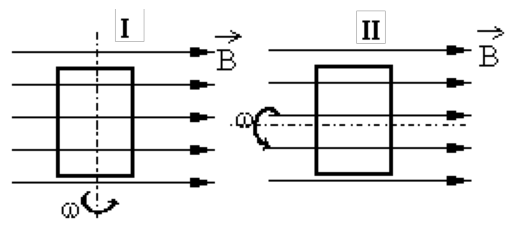





Задача: 24
Условие: На  рисунке справа представлен график изменения заряда конденсатора в колебательном  контуре с течением времени. На каком  из графиков правильно показан процесс изменения силы тока с течением времени в  этом колебательном контуре?


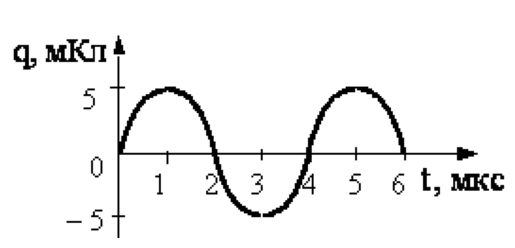

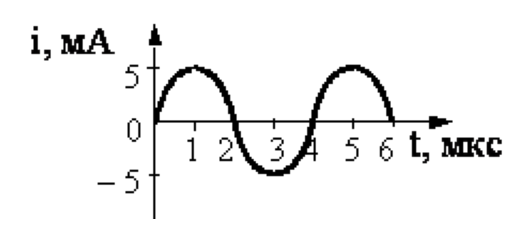

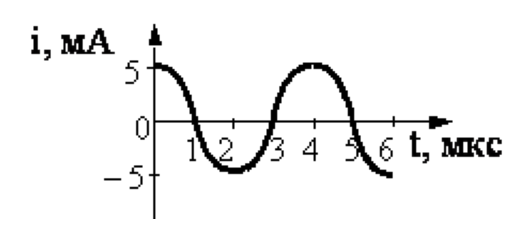

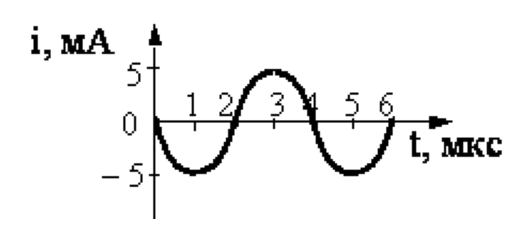

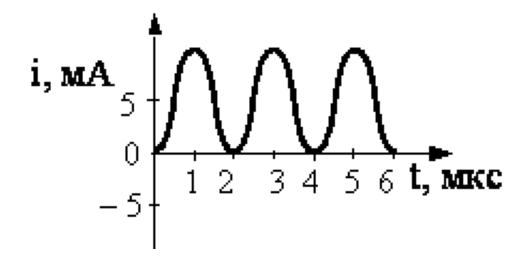





Задача: 25
Условие: Энергия  фотона, поглощаемого атомом при переходе из основного состояния с энергией E 0 в  возбужденное состояние с энергией E 1 , равна




Задача: 26
Условие: На  рисунках А, Б, В приведены спектры излучения паров стронция, неизвестного образца  и кальция. Можно утверждать, что в образце


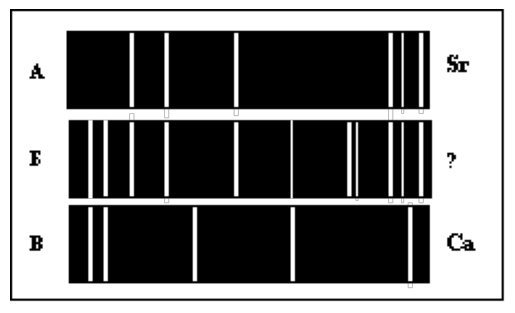





Задача: 27
Условие: Какая из  строчек таблицы правильно отражает структуру ядра 48 20 Cа? p – число протонов n – число нейтронов 1) 48 68 2) 28 20 3) 20 48 4) 20 28




Задача: 28
Условие: Полоний 214 84 Po превращается в висмут 210 83 Bi в результате радиоактивных  распадов:




Задача: 29
Условие: Красная  граница фотоэффекта исследуемого металла соответствует длине волны λкр = 600 нм. При освещении этого металла светом длиной волны λ максимальная кинетическая энергия выбитых из него  фотоэлектронов в 3 раза меньше энергии падающего света. Какова длина волны  λ падающего света?




Задача: 30
Условие: В лаборатории исследовалась зависимость напряжения на  обкладках конденсатора от заряда этого конденсатора. Результаты измерений  представлены в таблице. q, мкКл 0,1 0,2 0,3 0,4 0,5 U, кВ 0,5 1,5 3,0 3,5 3,8 Погрешности измерений величин   q   и   U   равнялись  соответственно 0,05 мкКл  и 0,25 кВ. Какой из графиков приведен правильно с учетом всех результатов  измерения и погрешнос

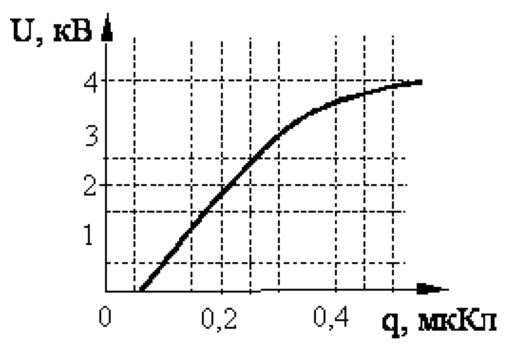

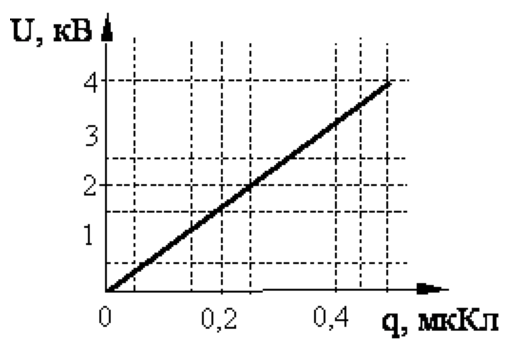

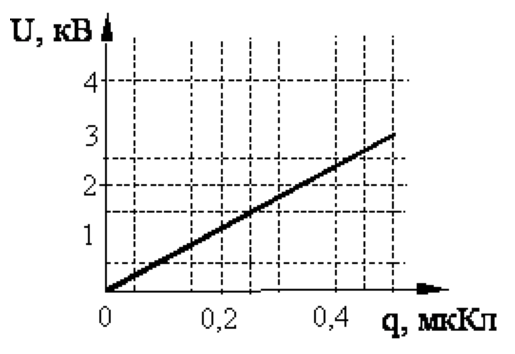

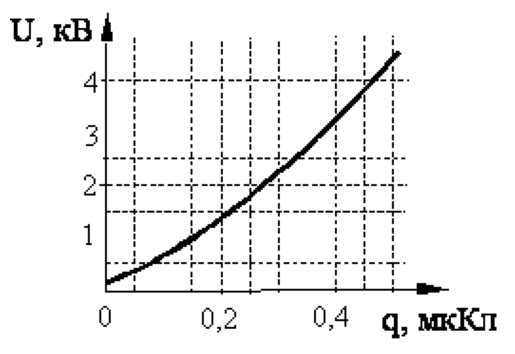





Задача: 1
Условие: Небольшой камень, брошенный с ровной горизонтальной поверхности земли под углом к горизонту, упал обратно на землю в 20 м от места броска. Чему была равна скорость камня через 1 с после броска, если в этот момент она была направлена горизонтально?




Задача: 2
Условие: 1 моль инертного газа сжали, совершив работу 600 Дж. В результате сжатия температура газа повысилась на 40 о С. Какое количество теплоты отдал газ?  Ответ округлите до целых.




Задача: 3
Условие: В электрическом поле, вектор напряженности которого направлен горизонтально и равен по модулю 1000 В/м, нить с подвешенным на ней маленьким заряженным шариком отклонилась на угол 45 о от вертикали. Масса шарика 1,4 г. Чему равен заряд шарика? Ответ выразите в микрокулонах (мкКл) и округлите до целых.




Задача: 4
Условие: Карандаш совмещен с главной оптической осью тонкой собирающей линзы, его длина равна фокусному расстоянию линзы f = 12 см. Середина карандаша находится на расстоянии 2f от линзы. Расс

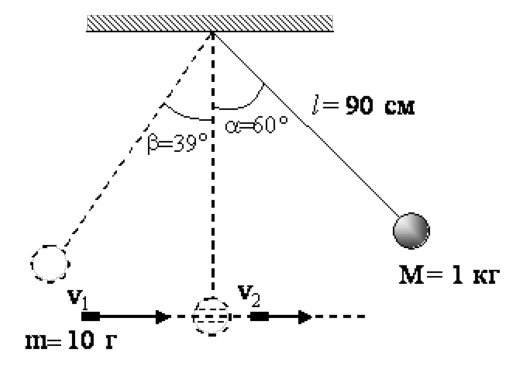





Задача: 2
Условие: Воздушный шар с газонепроницаемой оболочкой массой 400 кг заполнен гелием. На высоте, где температура воздуха  17 о С  и давление  10 5 Па, шар может удерживать груз массой 225 кг. Какова масса гелия в оболочке шара? Считать, что оболочка шара не оказывает сопротивления изменению объема шара. (Решение)




Задача: 3
Условие: К однородному медному цилиндрическому проводнику  длиной 10 м приложили разность потенциалов 1 В. Определите промежуток времени, в течение которого температура проводника повысится на 10 К. Изменением сопротивления проводника и рассеянием тепла при его нагревании пренебречь. (Удельное сопротивление меди 1,7 . 10 –8 Ом . м.) (Решение)




Задача: 4
Условие: В дно водоема глубиной 3 м вертикально вбита свая, скрытая под водой. Высота сваи 2 м. Свая отбрасывает на дне водоема тень длиной 0,75 м. Определите угол падения солнечных лучей на поверхность воды. Показатель преломления воды n =  4/3. (Решение)




Задача: 5
Условие: Фотокатод, покрытый 

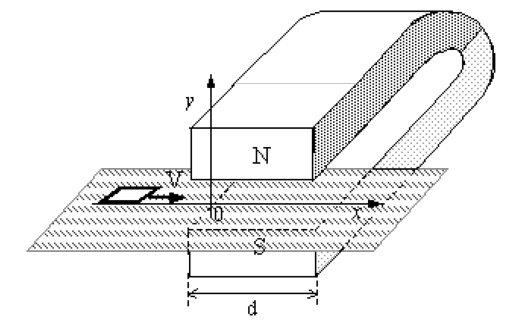

In [31]:
task2007 = df[df['Year'] == 2007]

check_parsing(task2007)

In [32]:
df.shape

(245, 6)

In [33]:
df.to_csv("problems.csv", index=False, encoding="utf-8-sig")

In [34]:
df.columns

Index(['Images', 'Number', 'Task', 'Choices', 'Year', 'Level'], dtype='object')

In [35]:
df[['Number', 'Task', 'Choices', 'Year', 'Level']]

Number                                               Task  \
0         1  На рисунке представлен график зависимости коор...   
1         2  На рис. А показаны направления скорости и уско...   
2         3  На рычаг действуют две силы, плечи которых рав...   
3         4  Предлагается два объяснения того экспериментал...   
4         5  Тележка массой m, движущаяся со скоростью v, с...   
..      ...                                                ...   
240       2  Воздушный шар с газонепроницаемой оболочкой ма...   
241       3  К однородному медному цилиндрическому проводни...   
242       4  В дно водоема глубиной 3 м вертикально вбита с...   
243       5  Фотокатод, покрытый кальцием (работа выхода 4,...   
244       6  Квадратная рамка со стороной   b = 5 см изгото...   

                                               Choices  Year Level  
0    ["v1  > v2  = v3", "v1  > v2  > v3", "v1  < v2...  2002     A  
1                                 ["1", "2", "3", "4"]  2002     A  
2    ["1 \u041d", "6 \u041d", "9 \u041d", "12 \u041d"]  2002     A  
3    ["\u0442\u043e\u043b\u044c\u043a\u043e \u0410"...  2002     A  
4                           ["0", "mv/2", "mv", "2mv"]  2002     A  
..                                                 ...   ...   ...  
240                                                nan  2007     С  
241                                                nan  2007     С  
242                                                nan  2007     С  
243                                                nan  2007     С  
244                                                nan  2007     С  

[245 rows x 5 columns]